In [1]:
## Version futuresales lib required = 0.1.11

!pip install -i https://test.pypi.org/simple/ futuresales_denissimo==0.1.11
# !pip install plotly==5.3.1
# !pip install neptune-client
# !pip install neptune-sklearn

Looking in indexes: https://test.pypi.org/simple/


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import futuresales as fs

from futuresales.distribution import from_pickle, to_pickle
from futuresales.utils import make_scaled, load_credentials
from futuresales.validation import Validator, causation_1_percent
from neptune.new.types import File

import seaborn as sns

/tmp/ipykernel_20492/1267431409.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [3]:
RUN_NAME = 'FSRES-17'

In [4]:
import neptune.new as neptune

cred = load_credentials('../../credentials.json')['projects']['fs-results']

run = neptune.init(
    api_token=cred['api_token'],
    project=cred['project'],
    run=RUN_NAME
)  # your credentials

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/denissimo/FS-Results/e/FSRES-17
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [16]:
task_df = {}

idx = pd.read_csv('../../tmp/idx.csv').rename({'id': 'object_id'}, axis=1)

task_df['test'] = pd.read_csv('../../tmp/task_df_test.csv').drop('Unnamed: 0', axis=1)
task_df['dynamic'] = from_pickle('../../tmp/id_sales_test.pkl')

In [6]:
run['dump/residuals'].download()
report = from_pickle('./residuals.pkl')
report

,valid_target,residuals,predicted,object_id
0,0.0,-0.036002,-0.036002,0
1,0.0,0.083914,0.083914,1
2,0.0,0.089714,0.089714,2
3,0.0,-0.036002,-0.036002,3
4,0.0,0.091025,0.091025,4
...,...,...,...,...
422572,0.0,0.138159,0.138159,422572
422573,0.0,0.094061,0.094061,422573
422574,0.0,0.117828,0.117828,422574
422575,0.0,0.094061,0.094061,422575


In [7]:
report = report.merge(idx, on='object_id', how='left')

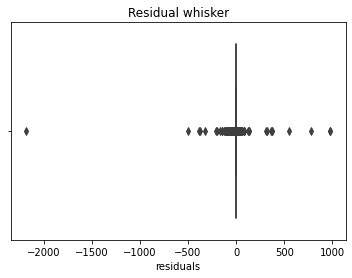

In [8]:
run['analysis/residuals/plots/whisker'].upload(File.as_image(sns.boxplot(data=report, x='residuals').set_title('Residual whisker').figure))

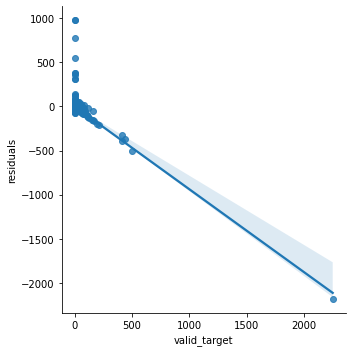

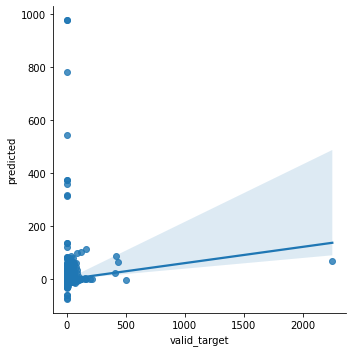

In [11]:
run['analysis/residuals/plots/dependecies'] = {
    'target_residual': File.as_image(sns.lmplot(data=report, x='valid_target', y='residuals').figure),
    'target_predicted': File.as_image(sns.lmplot(data=report, x='valid_target', y='predicted').figure),
}

In [12]:
stable_residual_interval = report.reset_index().rename(columns={'index': 'id'}).merge(idx)
stable_residual_interval['abs_residuals'] = abs(stable_residual_interval['residuals'])

In [14]:
giant_test, percent_str =  causation_1_percent(stable_residual_interval)

0.1% of objects cause 0.9803533984869324 of error


In [44]:
giant_test

,id,valid_target,residuals,predicted,object_id,Unnamed: 0,item_name,item_id,item_category_id,shop_name,shop_id,item_category_name,abs_residuals,part
343923,343923,15.0,-14.902502,0.097498,343923,343923,FABIAN LARA En Toute Intimite,3268,55,"Балашиха ТРК ""Октябрь-Киномир""",3,Музыка - CD локального производства,14.902502,0.000023
342805,342805,15.0,-14.902502,0.097498,342805,342805,ENIGMA Seven Lives Many Faces,3118,55,"Москва ТРК ""Атриум""",25,Музыка - CD локального производства,14.902502,0.000023
375171,375171,15.0,-14.902502,0.097498,375171,375171,SLIM Отличай людей,6304,55,"Тюмень ТЦ ""Зеленый Берег""",51,Музыка - CD локального производства,14.902502,0.000023
355666,355666,15.0,-14.902502,0.097498,355666,355666,LADY GAGA The Fame Monster 2CD,4289,55,"Сергиев Посад ТЦ ""7Я""",46,Музыка - CD локального производства,14.902502,0.000023
356703,356703,15.0,-14.902502,0.097498,356703,356703,LIMP BIZKIT Gold Cobra,4411,55,"Балашиха ТРК ""Октябрь-Киномир""",3,Музыка - CD локального производства,14.902502,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419944,419944,0.0,545.498540,545.498540,419944,419944,КЛАССИКА Бизе Жорж Щедрин Родион Кармен-сюи...,12532,55,"Волжский ТЦ ""Волга Молл""",4,Музыка - CD локального производства,545.498540,0.030570
419946,419946,0.0,781.362443,781.362443,419946,419946,КЛАССИКА Бизе Жорж Щедрин Родион Кармен-сюи...,12532,55,"Воронеж (Плехановская, 13)",6,Музыка - CD локального производства,781.362443,0.062721
419945,419945,0.0,976.963671,976.963671,419945,419945,КЛАССИКА Бизе Жорж Щедрин Родион Кармен-сюи...,12532,55,"Вологда ТРЦ ""Мармелад""",5,Музыка - CD локального производства,976.963671,0.098053
419983,419983,0.0,977.169256,977.169256,419983,419983,КЛАССИКА Бизе Жорж Щедрин Родион Кармен-сюи...,12532,55,"СПб ТК ""Сенная""",43,Музыка - CD локального производства,977.169256,0.098095


In [17]:
run['analysis/residuals/top_worst/magic_string'] = percent_str
run['analysis/residuals/top_worst/raw_giants'].upload(File.as_pickle(giant_test))


serieses = task_df['test'].groupby(['month_block', 'id']).item_cnt_day.sum().reset_index().set_index('id').index.value_counts().reset_index().rename({'id': 'appearence', 'index': 'id'}, axis=1)

In [19]:
top_50 = (giant_test.sort_values('part').reset_index()
    .groupby([
        'id', 'shop_id', 'item_id', 'shop_name', 'item_name'])
    .agg({
        'predicted': [np.mean],
        'valid_target': [np.mean], 
        'part': [np.mean], 
        'abs_residuals': [np.mean, lambda x: np.mean(x)**2]})
    .sort_values(('part', 'mean'))
    .tail(50)
    )
run['analysis/residuals/top_worst/top_50_objects'].upload(File.as_html(top_50))

In [20]:
top_15_shops = (giant_test.sort_values('part')
    .groupby([
        'shop_id', 'shop_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))
run['analysis/residuals/top_worst/top_15_shops'].upload(File.as_html(top_15_shops))

In [21]:
top_15_items= (giant_test.sort_values('part')
    .groupby([
        'item_id', 'item_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))
run['analysis/residuals/top_worst/top_15_items'].upload(File.as_html(top_15_items))

1
0


TypeError: no numeric data to plot

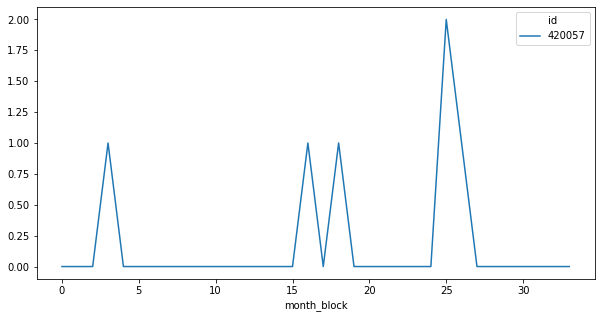

In [43]:
for i in range(0, 10):
    id_slice = top_50.reset_index().set_index('id').index.to_list()[-5 - 5*i: -5 - 5*(i - 1)] if i != 0 else top_50.reset_index().set_index('id').index.to_list()[-5: None]
    print(id_slice)
    fig = task_df['dynamic'][task_df['dynamic'].index.isin(id_slice)].transpose().plot(figsize=(10, 5)).figure
    run[f'analysis/residuals/plots/top_{5*i}-{5*(i + 1)}_items'].upload(File.as_image(fig))

In [45]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!
